<a href="https://colab.research.google.com/github/KenzaxTazi/Agri-Risk/blob/master/RFECV_monthly_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os, sys
path = '/content/drive/My Drive/GTC'
os.chdir(path)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import time
%matplotlib inline
from tqdm import tqdm

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

In [38]:
ten_day_df = pd.read_csv('head_of_soils_recommendations.csv')
ten_day_df

,Unnamed: 0,alloc_key,lon,lat,iso3,maize_a_2010,maize_a_2005,BEDD-01-05-2010,BEDD-02-05-2010,BEDD-03-05-2010,BEDD-04-05-2010,BEDD-05-05-2010,BEDD-06-05-2010,BEDD-07-05-2010,BEDD-08-05-2010,BEDD-09-05-2010,BEDD-10-05-2010,BEDD-11-05-2010,BEDD-12-05-2010,BEDD-01-15-2010,BEDD-02-15-2010,BEDD-03-15-2010,BEDD-04-15-2010,BEDD-05-15-2010,BEDD-06-15-2010,BEDD-07-15-2010,BEDD-08-15-2010,BEDD-09-15-2010,BEDD-10-15-2010,BEDD-11-15-2010,BEDD-12-15-2010,BEDD-01-25-2010,BEDD-02-25-2010,BEDD-03-25-2010,BEDD-04-25-2010,BEDD-05-25-2010,BEDD-06-25-2010,BEDD-07-25-2010,BEDD-08-25-2010,BEDD-09-25-2010,...,DTR-09-25-2010,DTR-10-25-2010,DTR-11-25-2010,DTR-12-25-2010,DTR-01-05-2005,DTR-02-05-2005,DTR-03-05-2005,DTR-04-05-2005,DTR-05-05-2005,DTR-06-05-2005,DTR-07-05-2005,DTR-08-05-2005,DTR-09-05-2005,DTR-10-05-2005,DTR-11-05-2005,DTR-12-05-2005,DTR-01-15-2005,DTR-02-15-2005,DTR-03-15-2005,DTR-04-15-2005,DTR-05-15-2005,DTR-06-15-2005,DTR-07-15-2005,DTR-08-15-2005,DTR-09-15-2005,DTR-10-15-2005,DTR-11-15-2005,DTR-12-15-2005,DTR-01-25-2005,DTR-02-25-2005,DTR-03-25-2005,DTR-04-25-2005,DTR-05-25-2005,DTR-06-25-2005,DTR-07-25-2005,DTR-08-25-2005,DTR-09-25-2005,DTR-10-25-2005,DTR-11-25-2005,DTR-12-25-2005
0,0,4383640,123.291667,53.541667,CHN,3918.1,2819.2,0.000000,0.000000,0.000000,0.000000,0.000000,41.363127,58.864516,37.987717,35.519341,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.397859,35.972803,70.771844,47.295640,13.864582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.759598,117.686572,78.207775,51.866659,0.000000,...,11.727703,13.787956,9.926498,11.371226,12.503196,12.908701,16.032727,13.402978,11.735192,16.610372,9.410874,15.312115,13.542417,16.038854,9.848100,12.936875,15.138467,19.237968,18.427092,11.584098,15.175377,14.674588,14.688044,15.483794,11.441020,11.420742,15.016444,10.487718,13.816922,18.504860,18.507736,15.031678,17.593290,15.704611,18.523022,14.092479,15.016566,13.988310,18.100036,12.329345
1,2,4393629,122.375000,53.458333,CHN,3119.3,2028.5,0.000000,0.000000,0.000000,0.000000,0.000000,46.733022,67.613537,43.898331,36.698276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.459904,39.495712,78.767241,52.374707,14.427820,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.772268,125.595174,83.146588,55.973652,0.000000,...,11.912833,13.628348,11.160431,11.007959,12.945838,12.618908,17.508302,13.575372,12.651447,16.761110,9.316199,15.640966,14.423927,16.998112,9.292246,12.221441,14.103506,20.599868,19.241434,12.576798,15.924542,14.954824,14.986558,15.608261,12.051438,11.944841,14.345663,10.443484,13.584308,18.917152,18.651182,15.191576,16.881676,16.390320,18.770228,14.457341,15.568386,14.757354,18.749596,12.080565
2,7,4403648,123.958333,53.375000,CHN,3230.1,2337.9,0.000000,0.000000,0.000000,0.000000,0.000000,42.146906,58.197767,38.470460,36.390766,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.700476,37.185835,69.226086,48.036306,16.367400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.950559,116.095221,79.417204,53.371251,0.000000,...,11.412658,13.940518,9.111539,11.555232,12.414833,13.285697,15.601179,13.165404,10.974052,16.134251,9.555662,14.871300,12.659969,15.561574,10.324795,13.343145,14.664218,18.112774,17.477607,11.057737,14.727950,14.167884,14.187781,15.036729,11.477290,11.496888,15.057879,11.031311,14.502568,18.348780,18.019471,14.658110,18.091173,15.529109,18.057473,14.120732,14.818996,13.382273,17.323588,12.099928
3,8,4403649,124.041667,53.375000,CHN,3119.3,2010.2,0.000000,0.000000,0.000000,0.000000,0.000000,42.653685,58.725946,39.027351,36.776440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.783617,37.781733,69.630878,48.656871,16.629891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.459567,116.369432,80.279322,54.095035,0.000000,...,11.393748,13.889010,8.999466,11.520067,12.391664,13.244279,15.525052,13.112559,10.872659,16.008852,9.590657,14.801929,12.553973,15.462869,10.335471,13

In [0]:
cols = ten_day_df.columns.tolist()
#cols

In [40]:
ten_day_features_df = ten_day_df.drop(['Unnamed: 0', 'alloc_key', 'alloc_key', 'iso3'], axis=1)
ten_day_features_df

,lon,lat,maize_a_2010,maize_a_2005,BEDD-01-05-2010,BEDD-02-05-2010,BEDD-03-05-2010,BEDD-04-05-2010,BEDD-05-05-2010,BEDD-06-05-2010,BEDD-07-05-2010,BEDD-08-05-2010,BEDD-09-05-2010,BEDD-10-05-2010,BEDD-11-05-2010,BEDD-12-05-2010,BEDD-01-15-2010,BEDD-02-15-2010,BEDD-03-15-2010,BEDD-04-15-2010,BEDD-05-15-2010,BEDD-06-15-2010,BEDD-07-15-2010,BEDD-08-15-2010,BEDD-09-15-2010,BEDD-10-15-2010,BEDD-11-15-2010,BEDD-12-15-2010,BEDD-01-25-2010,BEDD-02-25-2010,BEDD-03-25-2010,BEDD-04-25-2010,BEDD-05-25-2010,BEDD-06-25-2010,BEDD-07-25-2010,BEDD-08-25-2010,BEDD-09-25-2010,BEDD-10-25-2010,BEDD-11-25-2010,BEDD-12-25-2010,...,DTR-09-25-2010,DTR-10-25-2010,DTR-11-25-2010,DTR-12-25-2010,DTR-01-05-2005,DTR-02-05-2005,DTR-03-05-2005,DTR-04-05-2005,DTR-05-05-2005,DTR-06-05-2005,DTR-07-05-2005,DTR-08-05-2005,DTR-09-05-2005,DTR-10-05-2005,DTR-11-05-2005,DTR-12-05-2005,DTR-01-15-2005,DTR-02-15-2005,DTR-03-15-2005,DTR-04-15-2005,DTR-05-15-2005,DTR-06-15-2005,DTR-07-15-2005,DTR-08-15-2005,DTR-09-15-2005,DTR-10-15-2005,DTR-11-15-2005,DTR-12-15-2005,DTR-01-25-2005,DTR-02-25-2005,DTR-03-25-2005,DTR-04-25-2005,DTR-05-25-2005,DTR-06-25-2005,DTR-07-25-2005,DTR-08-25-2005,DTR-09-25-2005,DTR-10-25-2005,DTR-11-25-2005,DTR-12-25-2005
0,123.291667,53.541667,3918.1,2819.2,0.000000,0.000000,0.000000,0.000000,0.000000,41.363127,58.864516,37.987717,35.519341,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.397859,35.972803,70.771844,47.295640,13.864582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.759598,117.686572,78.207775,51.866659,0.000000,0.000000,0.000000,0.000000,...,11.727703,13.787956,9.926498,11.371226,12.503196,12.908701,16.032727,13.402978,11.735192,16.610372,9.410874,15.312115,13.542417,16.038854,9.848100,12.936875,15.138467,19.237968,18.427092,11.584098,15.175377,14.674588,14.688044,15.483794,11.441020,11.420742,15.016444,10.487718,13.816922,18.504860,18.507736,15.031678,17.593290,15.704611,18.523022,14.092479,15.016566,13.988310,18.100036,12.329345
1,122.375000,53.458333,3119.3,2028.5,0.000000,0.000000,0.000000,0.000000,0.000000,46.733022,67.613537,43.898331,36.698276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.459904,39.495712,78.767241,52.374707,14.427820,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.772268,125.595174,83.146588,55.973652,0.000000,0.000000,0.000000,0.000000,...,11.912833,13.628348,11.160431,11.007959,12.945838,12.618908,17.508302,13.575372,12.651447,16.761110,9.316199,15.640966,14.423927,16.998112,9.292246,12.221441,14.103506,20.599868,19.241434,12.576798,15.924542,14.954824,14.986558,15.608261,12.051438,11.944841,14.345663,10.443484,13.584308,18.917152,18.651182,15.191576,16.881676,16.390320,18.770228,14.457341,15.568386,14.757354,18.749596,12.080565
2,123.958333,53.375000,3230.1,2337.9,0.000000,0.000000,0.000000,0.000000,0.000000,42.146906,58.197767,38.470460,36.390766,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.700476,37.185835,69.226086,48.036306,16.367400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.950559,116.095221,79.417204,53.371251,0.000000,0.000000,0.000000,0.000000,...,11.412658,13.940518,9.111539,11.555232,12.414833,13.285697,15.601179,13.165404,10.974052,16.134251,9.555662,14.871300,12.659969,15.561574,10.324795,13.343145,14.664218,18.112774,17.477607,11.057737,14.727950,14.167884,14.187781,15.036729,11.477290,11.496888,15.057879,11.031311,14.502568,18.348780,18.019471,14.658110,18.091173,15.529109,18.057473,14.120732,14.818996,13.382273,17.323588,12.099928
3,124.041667,53.375000,3119.3,2010.2,0.000000,0.000000,0.000000,0.000000,0.000000,42.653685,58.725946,39.027351,36.776440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.783617,37.781733,69.630878,48.656871,16.629891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.459567,116.369432,80.279322,54.095035,0.000000,0.000000,0.000000,0.000000,...,11.393748,13.889010,8.999466,11.520067,12.391664,13.244279,15.525052,13.1125

In [41]:
ten_days = [
    'BEDD',
    'FD',
    'R20mm',
    'RR1',
    'DTR'
]
years = ['2005', '2010']
days = ['05', '15', '25']
months = [
    '01',
    '02',
    '03',
    '04',
    '05',
    '06',
    '07',
    '08',
    '09',
    '10',
    '11',
    '12'
]
all_ten_days = []
for feature in tqdm(ten_days):
    for month in months:
        for year in years:
            for day in days:
                all_ten_days.append(f'{feature}-{month}-{day}-{year}')
            ten_day_features_df[f'{feature}-{month}-{year}'] = ten_day_features_df[f'{feature}-{month}-05-{year}'] + ten_day_features_df[f'{feature}-{month}-15-{year}'] + ten_day_features_df[f'{feature}-{month}-25-{year}']
monthly_features_df = ten_day_features_df.drop(columns=all_ten_days)
del ten_day_features_df

100%|██████████| 5/5 [00:01<00:00,  2.20it/s]


In [0]:
limit_change_in_yield = True
limit = 0.5
monthly_features_df = monthly_features_df[abs(monthly_features_df['maize_a_2010'] - monthly_features_df['maize_a_2005']) / monthly_features_df['maize_a_2005'] < limit]


In [78]:
monthly_features_df

,lon,lat,maize_a_2010,maize_a_2005,BEDD-01-2005,BEDD-01-2010,BEDD-02-2005,BEDD-02-2010,BEDD-03-2005,BEDD-03-2010,BEDD-04-2005,BEDD-04-2010,BEDD-05-2005,BEDD-05-2010,BEDD-06-2005,BEDD-06-2010,BEDD-07-2005,BEDD-07-2010,BEDD-08-2005,BEDD-08-2010,BEDD-09-2005,BEDD-09-2010,BEDD-10-2005,BEDD-10-2010,BEDD-11-2005,BEDD-11-2010,BEDD-12-2005,BEDD-12-2010,FD-01-2005,FD-01-2010,FD-02-2005,FD-02-2010,FD-03-2005,FD-03-2010,FD-04-2005,FD-04-2010,FD-05-2005,FD-05-2010,FD-06-2005,FD-06-2010,...,RR1-05-2005,RR1-05-2010,RR1-06-2005,RR1-06-2010,RR1-07-2005,RR1-07-2010,RR1-08-2005,RR1-08-2010,RR1-09-2005,RR1-09-2010,RR1-10-2005,RR1-10-2010,RR1-11-2005,RR1-11-2010,RR1-12-2005,RR1-12-2010,DTR-01-2005,DTR-01-2010,DTR-02-2005,DTR-02-2010,DTR-03-2005,DTR-03-2010,DTR-04-2005,DTR-04-2010,DTR-05-2005,DTR-05-2010,DTR-06-2005,DTR-06-2010,DTR-07-2005,DTR-07-2010,DTR-08-2005,DTR-08-2010,DTR-09-2005,DTR-09-2010,DTR-10-2005,DTR-10-2010,DTR-11-2005,DTR-11-2010,DTR-12-2005,DTR-12-2010
0,123.291667,53.541667,3918.1,2819.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.069718,51.157457,131.072950,195.022503,233.252640,207.844135,155.706710,137.150016,15.442465,49.383923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.0,31.0,28.0,28.0,31.0,31.0,30.00,30.000,17.611111,12.430556,1.465278,0.847222,...,10.986111,8.583333,11.500000,11.368056,9.819444,19.583333,12.430556,10.569444,10.583333,4.000000,1.881944,10.534722,5.048611,4.583333,2.034722,4.416667,41.458586,40.545901,50.651529,50.259202,52.967555,56.858984,40.018753,44.579175,44.503859,45.102582,46.989570,49.639587,42.621941,36.801490,44.888387,39.978604,40.000002,43.589581,41.447906,38.357178,42.964580,38.464582,35.753938,35.565589
2,123.958333,53.375000,3230.1,2337.9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.127754,54.651035,131.682904,195.427961,232.696246,206.841057,159.315999,139.878016,19.254828,52.758167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.0,31.0,28.0,28.0,31.0,31.0,30.00,30.000,14.083333,11.833333,1.583333,0.583333,...,12.833333,8.562500,13.166667,11.083333,7.875000,19.145833,11.833333,10.958333,10.250000,3.895833,1.708333,9.895833,5.250000,4.562500,2.750000,4.750000,41.581619,40.944014,49.747251,49.048437,51.098257,54.504991,38.881252,43.612502,43.793174,44.519078,45.831243,48.681249,41.800917,35.978750,44.028761,40.016271,38.956256,42.268750,40.440735,37.020118,42.706261,38.081249,36.474383,35.592393
4,123.041667,53.291667,3918.1,2819.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.538883,48.659639,132.315645,196.586523,232.973297,212.047176,157.401400,140.145201,15.514391,51.178022,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.0,31.0,28.0,28.0,31.0,31.0,30.00,30.000,18.868056,13.333333,1.916667,1.833333,...,8.798611,8.083333,11.500000,11.534722,10.381944,19.152778,12.847222,10.048611,9.736111,4.034722,2.833333,10.048611,5.416667,3.631944,2.000000,6.444444,41.957946,41.317067,51.974885,51.749297,54.254969,58.168627,40.960411,44.960419,45.057066,45.670912,47.599992,50.560413,42.736980,37.531577,45.296377,40.243307,41.200005,44.799997,42.952882,39.853590,43.404167,39.018754,36.234884,35.968608
5,123.125000,53.291667,3918.1,2819.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.875249,49.327763,131.751286,196.073971,232.886382,211.444204,157.522312,139.658466,16.053787,51.734168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.0,31.0,28.0,28.0,31.0,31.0,30.00,30.000,18.854167,13.166667,1.916667,1.833333,...,8.979167,8.083333,11.666667,11.687500,10.229167,19.125000,12.875000,10.062500,9.875000,4.020833,2.833333,10.062500,5.250000,3.812500,2.000000,5.833333,42.012974,41.371530,51.870400,51.641775,53.955161,57.829820,40.856244,44.956255,44.910374,45.526169,47.499989,50.456246,42.642634,37.380615,45.200080,40.246135,41.000004,44.599997,42.748973,39.638324,43.412500,38.981254,36.338797,35.968537
20,126.625000,51.041667,2857.9,1934.8,0.000000,0.000000,

In [0]:
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn import feature_selection
from sklearn.model_selection import KFold
import time

In [44]:
!pip3 install xgboost

In [0]:
import xgboost as xgb

In [0]:
pipe = Pipeline(
    [
        ('std_scaler', preprocessing.StandardScaler()),
        ("RF", xgb.XGBRegressor(tree_method='gpu_hist', objective='reg:squarederror', rondom_state=42, error_score='raise', gamma=1.2, max_depth=8, min_child_weight=14))
         #RandomForestRegressor(random_state=42, n_estimators=100,n_jobs=-1, verbose=10))
    ])

In [0]:
class PipelineRFE(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

In [0]:
feature_names = monthly_features_df.drop(['maize_a_2010','lat','lon'], axis=1).columns

In [79]:
#df.replace([np.inf, -np.inf], np.nan)
#monthly_features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
monthly_features_df.dropna(inplace=True)
X = monthly_features_df.drop(['maize_a_2010'], axis=1).drop(['lat','lon'], axis=1).sample(n=100000, random_state=42)
y = monthly_features_df['maize_a_2010'].sample(n=100000, random_state=42)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
start = time.time()
pipe = PipelineRFE([('std_scaler', preprocessing.StandardScaler()), 
                    ("RF", xgb.XGBRegressor(tree_method='gpu_hist', objective='reg:squarederror', random_state=42, error_score='raise', gamma=1.2, max_depth=12, min_child_weight=20))], verbose=3)
     #("RF", RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1))], verbose=3)
_ = KFold(random_state=42, shuffle=True)
feature_selector_cv = feature_selection.RFECV(pipe, cv=3, step=1, scoring="neg_mean_squared_error")
feature_selector_cv.fit(X, y)
stop=time.time()
print(f"training time: {stop-start}s")
print(f"number of features: {feature_selector_cv.n_features_}")

[Pipeline] ........ (step 1 of 2) Processing std_scaler, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing RF, total=   4.4s
[Pipeline] ........ (step 1 of 2) Processing std_scaler, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing RF, total=   4.3s
[Pipeline] ........ (step 1 of 2) Processing std_scaler, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing RF, total=   4.4s
[Pipeline] ........ (step 1 of 2) Processing std_scaler, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing RF, total=   4.4s
[Pipeline] ........ (step 1 of 2) Processing std_scaler, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing RF, total=   4.3s
[Pipeline] ........ (step 1 of 2) Processing std_scaler, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing RF, total=   4.5s
[Pipeline] ........ (step 1 of 2) Processing std_scaler, total=   0.2s
[Pipeline] ................ (step 2 of 2) Processing RF, total=   4.4s
[Pipel

In [94]:
cv_grid_rmse = np.sqrt(-feature_selector_cv.grid_scores_)
cv_grid_rmse

array([990.30722186, 964.0577573 , 917.10620966, 878.64121886,
       852.48816328, 839.83477443, 829.73241382, 821.33614732,
       814.88308794, 806.11236838, 800.10344306, 794.1908496 ,
       792.72361641, 790.5796402 , 786.32974164, 767.17053724,
       747.04900512, 726.08666235, 707.64117985, 698.16915565,
       692.54364743, 687.94076882, 685.193307  , 680.55704258,
       677.10231068, 675.60212798, 672.41802421, 671.19884844,
       667.16602395, 666.88908095, 665.64911138, 665.12370402,
       664.80177578, 663.1168121 , 661.39974016, 658.96149095,
       656.96397162, 659.73261877, 657.3368858 , 658.08376627,
       654.55254965, 656.38424102, 653.50041049, 653.92547236,
       655.03316315, 653.49808076, 653.57355241, 650.97812398,
       651.59530564, 651.27067715, 650.71999698, 650.83710917,
       649.2086538 , 649.6422514 , 649.06452393, 650.28652944,
       648.36844373, 649.69175774, 647.18133814, 648.42288906,
       648.68210823, 647.1054376 , 646.68597905, 645.52

In [95]:
selected_features = feature_names[feature_selector_cv.support_].tolist()
selected_features

['maize_a_2005',
 'BEDD-01-2005',
 'BEDD-01-2010',
 'BEDD-02-2005',
 'BEDD-02-2010',
 'BEDD-03-2005',
 'BEDD-03-2010',
 'BEDD-04-2005',
 'BEDD-04-2010',
 'BEDD-05-2005',
 'BEDD-05-2010',
 'BEDD-06-2005',
 'BEDD-06-2010',
 'BEDD-07-2005',
 'BEDD-07-2010',
 'BEDD-08-2005',
 'BEDD-08-2010',
 'BEDD-09-2005',
 'BEDD-09-2010',
 'BEDD-10-2005',
 'BEDD-10-2010',
 'BEDD-11-2005',
 'BEDD-11-2010',
 'BEDD-12-2005',
 'BEDD-12-2010',
 'FD-01-2005',
 'FD-01-2010',
 'FD-02-2005',
 'FD-02-2010',
 'FD-03-2005',
 'FD-03-2010',
 'FD-04-2005',
 'FD-04-2010',
 'FD-05-2005',
 'FD-05-2010',
 'FD-06-2005',
 'FD-06-2010',
 'FD-07-2010',
 'FD-09-2005',
 'FD-09-2010',
 'FD-10-2005',
 'FD-10-2010',
 'FD-11-2005',
 'FD-11-2010',
 'FD-12-2005',
 'FD-12-2010',
 'R20mm-01-2005',
 'R20mm-01-2010',
 'R20mm-02-2005',
 'R20mm-02-2010',
 'R20mm-03-2005',
 'R20mm-03-2010',
 'R20mm-04-2005',
 'R20mm-04-2010',
 'R20mm-05-2005',
 'R20mm-05-2010',
 'R20mm-06-2005',
 'R20mm-06-2010',
 'R20mm-07-2010',
 'R20mm-08-2005',
 'R20mm-

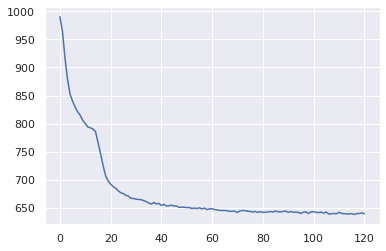

In [96]:
plt.plot(cv_grid_rmse)

In [98]:
list(set(feature_names.tolist())-set(selected_features))

['FD-07-2005', 'FD-08-2010', 'R20mm-07-2005', 'FD-08-2005']